# Using NN to study the Ising model phase transition

Notebook based on the paper:

**Machine learning phases of matter.** ([Link](http://arxiv.org/abs/1605.01735%0Ahttp://dx.doi.org/10.1038/nphys4035))

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle,os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers
from keras import optimizers
import sys, os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Using TensorFlow backend.


In [2]:
plt.rcParams['figure.figsize'] = [6.32, 5.11]
plt.rcParams['figure.constrained_layout.use'] = True

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.labelpad'] = 15

plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.major.width'] = 3

plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.major.width'] = 3

plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.markerscale'] = 1

plt.rcParams['lines.markersize'] = 9
plt.rcParams['lines.linewidth'] = 2

In [3]:
L = 40
samples_number = 10000
temperatures = np.arange(0.25, 4.01, 0.25)
dataset_size = 150000

In [4]:
data = pickle.load(open('../Data/Ising2DFM_reSample_L40_T=All.pkl','rb'))
X = np.unpackbits(data).astype(int).reshape(-1, L * L)
del data

In [5]:
temp_val = np.hstack([np.repeat(temp, samples_number) for temp in temperatures])
train_idx = np.random.choice(X.shape[0], size=dataset_size, replace=False)

In [6]:
aux = np.arange(X.shape[0])
test_idx = np.asarray(list(set(aux).difference(set(train_idx))))

In [7]:
Y = np.zeros(temp_val.shape)
Y = np.where(temp_val < 2.2691, 1, Y)

In [8]:
x_train = X[train_idx]
y_label = Y[train_idx]
x_test = X[test_idx]
y_test = Y[test_idx]
del Y, X

In [9]:
#model = Sequential()
#model.add(Dense(100, input_shape=(L * L, ), activation='sigmoid'))
#model.add(Dropout(0.5))
#model.add(Dense(1, activation='sigmoid'))
#model.compile(optimizer='adam',
#              loss='binary_crossentropy',
#              metrics=['accuracy'])

In [10]:
# A rede não consegue treinar se os valores do modelo de Ising forem +-1, provavelmente é necessário 
# fazer algum preprocessamento nos dados.
x_train = np.where(x_train==0, -1, x_train)
model = Sequential()
model.add(Dense(100, input_shape=(L * L, ), activation='tanh'))#, kernel_regularizer=regularizers.l1(0.01)))
model.add(Dropout(0.15))
#model.add(Dense(10, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [11]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               160100    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 160,201
Trainable params: 160,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_label, validation_split=0.1, batch_size=64, epochs=5)

Train on 135000 samples, validate on 15000 samples
Epoch 1/5
135000/135000 [==============================] - 5s 34us/step - loss: 0.5923 - accuracy: 0.7125 - val_loss: 0.5778 - val_accuracy: 0.7024
Epoch 2/5
135000/135000 [==============================] - 5s 34us/step - loss: 0.5718 - accuracy: 0.7197 - val_loss: 0.5607 - val_accuracy: 0.7061
Epoch 3/5
135000/135000 [==============================] - 4s 33us/step - loss: 0.5520 - accuracy: 0.7293 - val_loss: 0.5424 - val_accuracy: 0.7131
Epoch 4/5
102784/135000 [=====================>........] - ETA: 1s - loss: 0.5348 - accuracy: 0.7382

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)

In [15]:
print('Test accuracy: {1:6.4f} \nTest loss: {0:6.4f}'.format(score[0], score[1]))

Test accuracy: 0.6176 
Test loss: 0.6705


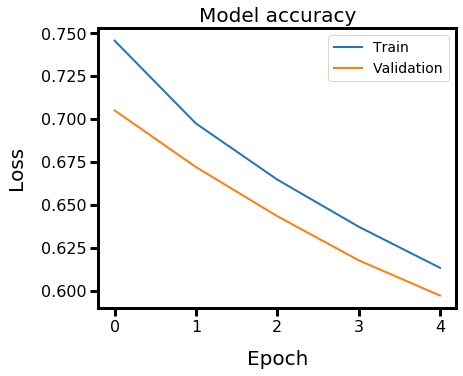

In [16]:
# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

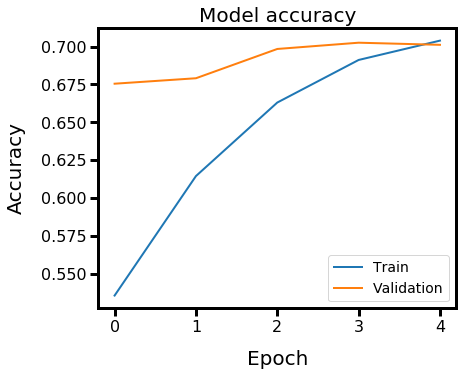

In [17]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [18]:
res = model.predict(x_test)

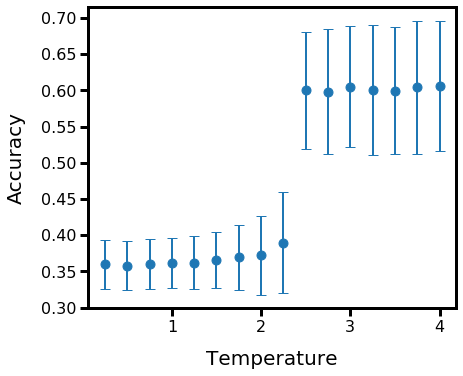

In [19]:
acc = np.zeros(np.unique(temp_val).shape[0])
acc_std = np.zeros(np.unique(temp_val).shape[0])

for idx, temp in enumerate(np.unique(temp_val)):

    pos = np.argwhere(temp_val[test_idx] == temp)
    
    acc[idx] = np.mean(np.abs(res[pos] - y_test[pos]))
    acc_std[idx] = np.std(np.abs(res[pos] - y_test[pos]))

plt.errorbar(x=np.unique(temp_val), y=acc,
             yerr=acc_std, fmt='o', capsize=5)

plt.xlabel('Temperature')
plt.ylabel('Accuracy')
plt.show()

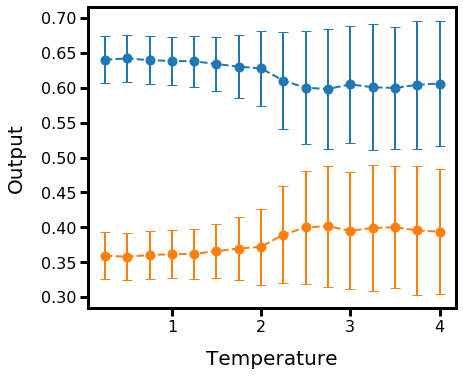

In [20]:
#%matplotlib notebook

output_mean = np.zeros(np.unique(temp_val).shape[0])
output_std = np.zeros(np.unique(temp_val).shape[0])

for idx, temp in enumerate(np.unique(temp_val)):

    pos = np.argwhere(temp_val[test_idx] == temp)
    
    output_mean[idx] = np.mean(res[pos])
    output_std[idx] = np.std(res[pos])

plt.errorbar(x=np.unique(temp_val), y=output_mean, yerr=output_std,
             fmt='o', capsize=5, linestyle='--')
plt.errorbar(x=np.unique(temp_val), y=np.abs(output_mean - 1),
             yerr=output_std, fmt='o', capsize=5, linestyle='--')


plt.ylabel('Output')
plt.xlabel('Temperature')
plt.show()